# Data Columns Analysis

## Imports

In [1]:
from src.io_ops import read_csv_safely
from src import paths

BASE_PATH = paths.RAW_DATA_DIR / "Base.csv"

## Plots helper function

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot(x0, x1, col_title):

    # Shared bins and per-class normalized counts
    bins = np.linspace(min(x0.min(), x1.min()), max(x0.max(), x1.max()), 30)
    c0, edges = np.histogram(x0, bins=bins)
    c1, _     = np.histogram(x1, bins=bins)
    c0 = c0 / c0.sum() if c0.sum() else c0
    c1 = c1 / c1.sum() if c1.sum() else c1
    centers = (edges[:-1] + edges[1:]) / 2
    bin_w = (edges[1] - edges[0])
    bar_w = bin_w * 0.45

    plt.figure(figsize=(7, 4))
    plt.bar(centers - bar_w/2, c0, width=bar_w, color='blue', edgecolor='white', alpha=0.85, label='Non-fraud (0)')
    plt.bar(centers + bar_w/2, c1, width=bar_w, color='red', edgecolor='white', alpha=0.85, label='Fraud (1)')
    plt.xlabel(f'{col_title}')
    plt.ylabel('Relative frequency per class')
    plt.title(f'{col_title} by fraud_bool (normalized)')
    plt.legend()
    plt.tight_layout()
    plt.show()

from collections import Counter

def plot_categorical(x0, x1, col_title):
    """
    Plota barras lado a lado (freq. relativa por classe) para uma feature categórica.
    x0: array-like das categorias para a classe 0 (ex.: não fraude)
    x1: array-like das categorias para a classe 1 (ex.: fraude)
    col_title: nome da coluna/feature (str)
    """

    def _to_key(v):
        # Normaliza valores para strings, tratando missing de forma consistente
        if v is None:
            return "(missing)"
        try:
            # Trata NaN (float('nan') != float('nan'))
            if isinstance(v, float) and np.isnan(v):
                return "(missing)"
        except Exception:
            pass
        return str(v)

    # Normaliza entradas para chaves categóricas
    x0k = [_to_key(v) for v in x0]
    x1k = [_to_key(v) for v in x1]

    # Contagens por categoria
    c0 = Counter(x0k)
    c1 = Counter(x1k)

    n0 = sum(c0.values())
    n1 = sum(c1.values())

    # Universo de categorias (ordenado por frequência total decrescente)
    all_cats = list(set(list(c0.keys()) + list(c1.keys())))
    all_cats.sort(key=lambda k: c0.get(k, 0) + c1.get(k, 0), reverse=True)

    # Se houver categorias demais, opcional: mantém top-N e agrega resto em "Other"
    MAX_CATS = 25
    if len(all_cats) > MAX_CATS:
        top = set(all_cats[:MAX_CATS-1])
        other_label = "Other"
        c0_agg = Counter({k: v for k, v in c0.items() if k in top})
        c1_agg = Counter({k: v for k, v in c1.items() if k in top})
        # soma o resto
        c0_agg[other_label] += sum(v for k, v in c0.items() if k not in top)
        c1_agg[other_label] += sum(v for k, v in c1.items() if k not in top)
        all_cats = list(top) + [other_label]
        # reordena com "Other" no fim
        all_cats.sort(key=lambda k: (k == other_label, -(c0_agg.get(k,0)+c1_agg.get(k,0))))
        c0, c1 = c0_agg, c1_agg

    # Frequências relativas por classe
    freq0 = np.array([c0.get(cat, 0) for cat in all_cats], dtype=float)
    freq1 = np.array([c1.get(cat, 0) for cat in all_cats], dtype=float)

    if n0 > 0:
        freq0 /= n0
    if n1 > 0:
        freq1 /= n1

    # Plot lado a lado
    idx = np.arange(len(all_cats))
    bar_w = 0.45

    plt.figure(figsize=(max(7, min(14, 0.5*len(all_cats)+3)), 4.5))
    plt.bar(idx - bar_w/2, freq0, width=bar_w, color='blue', edgecolor='white', alpha=0.85, label='Non-fraud (0)')
    plt.bar(idx + bar_w/2, freq1, width=bar_w, color='red',  edgecolor='white', alpha=0.85, label='Fraud (1)')

    plt.xticks(idx, all_cats, rotation=45 if len(all_cats) > 6 else 0, ha='right' if len(all_cats) > 6 else 'center')
    plt.ylabel('Relative frequency per class')
    plt.xlabel(f'{col_title}')
    plt.title(f'{col_title} (categorical) by fraud_bool (normalized)')
    plt.legend()
    plt.tight_layout()
    plt.show()


## Data import

In [3]:
df = read_csv_safely(BASE_PATH)

# Columns

## Column definitions (Base.csv)

- **fraud_bool** *(binary)* — Label indicating whether the application is fraudulent (1) or not (0).  
- **month** *(numeric)* — Month index of the application (0–7).  
- **income** *(numeric)* — Applicant’s annual income (decile form, 0.1–0.9).  
- **name_email_similarity** *(numeric)* — Similarity between applicant name and email (0–1; higher = more similar).  
- **prev_address_months_count** *(numeric)* — Months at previous address (−1 marks missing).  
- **current_address_months_count** *(numeric)* — Months at current address (−1 marks missing).  
- **customer_age** *(numeric)* — Age in years, rounded to decade (10–90).  
- **days_since_request** *(numeric)* — Days since the application was made (0–79).  
- **intended_balcon_amount** *(numeric)* — Initial transferred amount for the application (negatives denote missing).  
- **payment_type** *(categorical)* — Credit payment plan type (5 anonymized categories).  
- **zip_count_4w** *(numeric)* — # applications from same ZIP in last 4 weeks.  
- **velocity_6h** *(numeric)* — Avg. applications/hour in last 6 hours.  
- **velocity_24h** *(numeric)* — Avg. applications/hour in last 24 hours.  
- **velocity_4w** *(numeric)* — Avg. applications/hour in last 4 weeks.  
- **bank_branch_count_8w** *(numeric)* — # applications in the selected branch in last 8 weeks.  
- **date_of_birth_distinct_emails_4w** *(numeric)* — # distinct emails sharing the same DOB in last 4 weeks.  
- **employment_status** *(categorical)* — Applicant’s employment status (7 anonymized categories).  
- **credit_risk_score** *(numeric)* — Internal application risk score.  
- **email_is_free** *(binary)* — Whether the email domain is free or paid.  
- **housing_status** *(categorical)* — Current residential status (7 anonymized categories).  
- **phone_home_valid** *(binary)* — Validity of the provided home phone.  
- **phone_mobile_valid** *(binary)* — Validity of the provided mobile phone.  
- **bank_months_count** *(numeric)* — Tenure (months) of any prior account with the bank (−1 marks missing).  
- **has_other_cards** *(binary)* — Whether applicant has other cards at the bank.  
- **proposed_credit_limit** *(numeric)* — Proposed credit limit (e.g., 200–2000 in Base).  
- **foreign_request** *(binary)* — Request originated from a different country than the bank’s.  
- **source** *(categorical)* — Online application source (browser **INTERNET** vs. app **TELEAPP**).  
- **session_length_in_minutes** *(numeric)* — Session duration on banking site (−1 marks missing).  
- **device_os** *(categorical)* — Device operating system (Windows, macOS, Linux, X11, other).  
- **keep_alive_session** *(binary)* — Whether “keep me logged in” was enabled.  
- **device_distinct_emails_8w** *(numeric)* — # distinct emails seen from this device in last 8 weeks (negative values mark missing).  
- **device_fraud_count** *(numeric)* — Count of prior fraudulent applications from this device.  

# **fraud_bool** *(binary)* — Label indicating whether the application is fraudulent (1) or not (0). 

In [4]:
fraud_bool_col = df["fraud_bool"]

fraud_bool_col.describe()

count    1000000.000000
mean           0.011029
std            0.104438
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max            1.000000
Name: fraud_bool, dtype: float64

# **income** *(numeric)* — Applicant’s annual income (decile form, 0.1–0.9).  

In [5]:
income_col = df["income"]

income_col.describe()

count    1000000.000000
mean           0.562696
std            0.290343
min            0.100000
25%            0.300000
50%            0.600000
75%            0.800000
max            0.900000
Name: income, dtype: float64

Income - Already normalized!

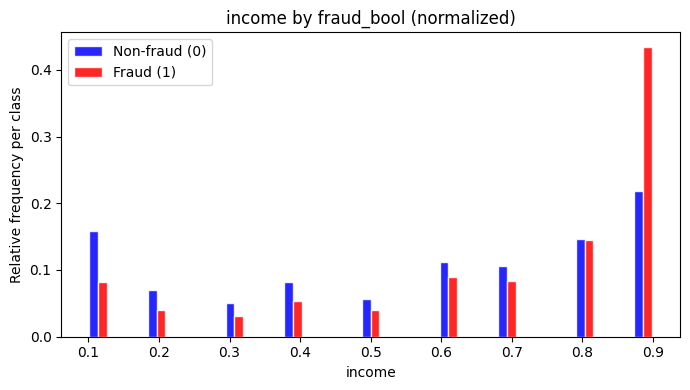

In [6]:
import numpy as np
import matplotlib.pyplot as plt

x0 = df.loc[df['fraud_bool'] == 0, 'income'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'income'].dropna()

plot(x0, x1, "income")

# **name_email_similarity** *(numeric)* — Similarity between applicant name and email (0–1; higher = more similar).  

In [7]:
name_email_similarity_col = df["name_email_similarity"]

name_email_similarity_col.describe()

count    1000000.000000
mean           0.493694
std            0.289125
min            0.000001
25%            0.225216
50%            0.492153
75%            0.755567
max            0.999999
Name: name_email_similarity, dtype: float64

Name-Email Similarity -> already between 0 and 1!

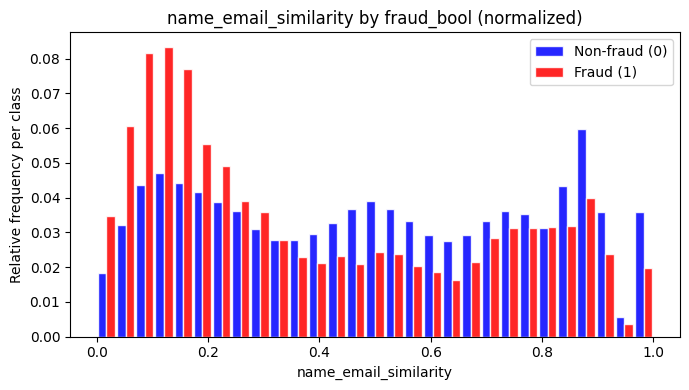

In [8]:
x0 = df.loc[df['fraud_bool'] == 0, 'name_email_similarity'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'name_email_similarity'].dropna()

plot(x0, x1, "name_email_similarity")

# **prev_address_months_count** *(numeric)* — Months at previous address (−1 marks missing).  

In [9]:
prev_address_months_count_col_missing = df.loc[df['prev_address_months_count'] == -1, "prev_address_months_count"] 

prev_address_months_count_col = df["prev_address_months_count"]

print("We have ", prev_address_months_count_col_missing.count(), " missing values in the prev_address_months_count column. \n", prev_address_months_count_col_missing.count(), "\n",prev_address_months_count_col.describe())

We have  712920  missing values in the prev_address_months_count column. 
 712920 
 count    1000000.000000
mean          16.718568
std           44.046230
min           -1.000000
25%           -1.000000
50%           -1.000000
75%           12.000000
max          383.000000
Name: prev_address_months_count, dtype: float64


In [10]:
#NOTE: Here we have -1 values, they are missing values. We can't normalize taking into account missing values. Right?
# The -1 values are around 71% of the data !!!!!!

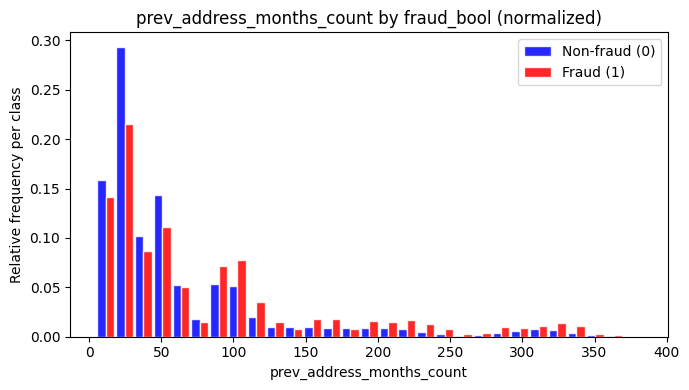

In [11]:
x0 = df.loc[df['fraud_bool'] == 0, 'prev_address_months_count'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'prev_address_months_count'].dropna()

x0 = x0[x0 != -1]
x1 = x1[x1 != -1]

plot(x0, x1, "prev_address_months_count")

# **current_address_months_count** *(numeric)* — Months at current address (−1 marks missing). 

In [14]:

current_address_months_count_missing = df.loc[df['current_address_months_count'] == -1, "current_address_months_count"] 

current_address_months_count = df["current_address_months_count"]

print("We have ", current_address_months_count_missing.count(), " missing values in the current_address_months_count column. \n", current_address_months_count_missing.count(), "\n",current_address_months_count.describe())

We have  4254  missing values in the current_address_months_count column. 
 4254 
 count    1000000.000000
mean          86.587867
std           88.406599
min           -1.000000
25%           19.000000
50%           52.000000
75%          130.000000
max          428.000000
Name: current_address_months_count, dtype: float64


In [15]:
# NOTE: Here we have -1 values, they are missing values. We can't normalize taking into account missing values. Right?
# The -1 values are around 0.43% of the data.

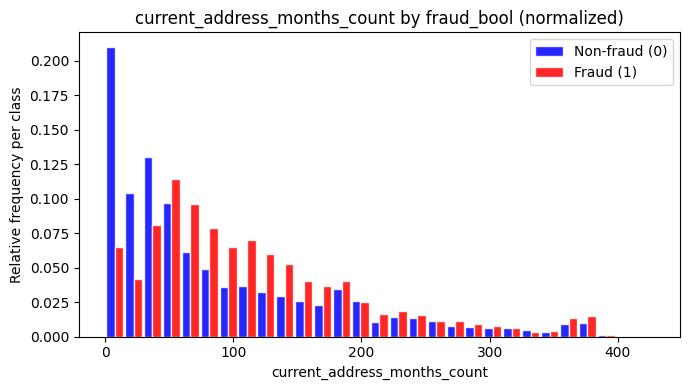

In [16]:
x0 = df.loc[df['fraud_bool'] == 0, 'current_address_months_count'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'current_address_months_count'].dropna()

x0 = x0[x0 != -1]
x1 = x1[x1 != -1]

plot(x0, x1, "current_address_months_count")

# **customer_age** *(numeric)* — Age in years, rounded to decade (10–90).  

In [17]:
customer_age_col = df["customer_age"]

customer_age_col.describe()

count    1000000.000000
mean          33.689080
std           12.025799
min           10.000000
25%           20.000000
50%           30.000000
75%           40.000000
max           90.000000
Name: customer_age, dtype: float64

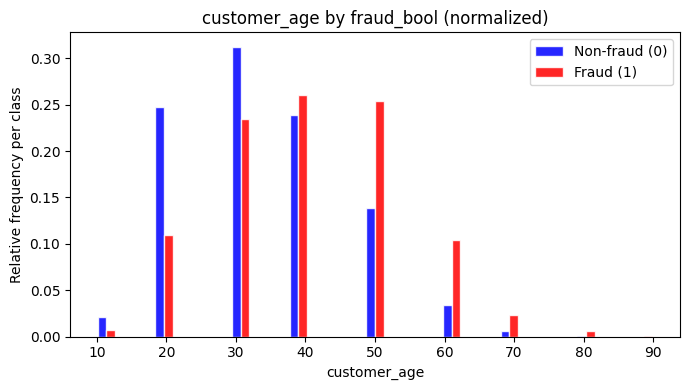

In [18]:
x0 = df.loc[df['fraud_bool'] == 0, 'customer_age'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'customer_age'].dropna()


plot(x0, x1, "customer_age")

# 

# **days_since_request** *(numeric)* — Days since the application was made (0–79). 

In [19]:
days_since_request_col = df["days_since_request"]

days_since_request_col.describe()

count    1.000000e+06
mean     1.025705e+00
std      5.381835e+00
min      4.036860e-09
25%      7.193246e-03
50%      1.517574e-02
75%      2.633069e-02
max      7.845690e+01
Name: days_since_request, dtype: float64

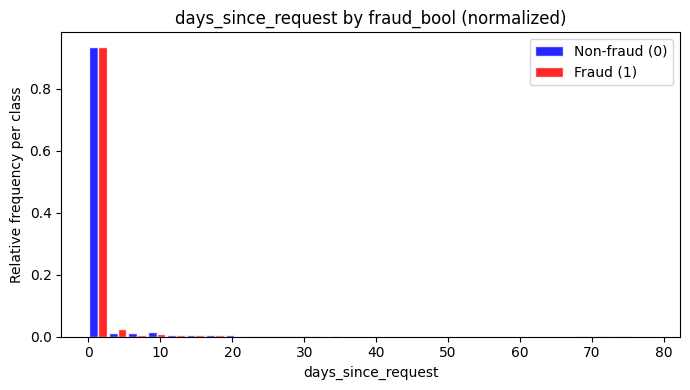

In [20]:
x0 = df.loc[df['fraud_bool'] == 0, 'days_since_request'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'days_since_request'].dropna()

plot(x0, x1, "days_since_request")

 # **intended_balcon_amount** *(numeric)* — Initial transferred amount for the application (negatives denote missing). 

In [21]:
intended_balcon_amount_col = df["intended_balcon_amount"]
intended_balcon_amount_col_missing = df.loc[df['intended_balcon_amount'] < 0, "intended_balcon_amount"]

print("We have ", intended_balcon_amount_col_missing.count(), " missing values in the intended_balcon_amount column. \n",intended_balcon_amount_col.describe())

We have  742523  missing values in the intended_balcon_amount column. 
 count    1000000.000000
mean           8.661499
std           20.236155
min          -15.530555
25%           -1.181488
50%           -0.830507
75%            4.984176
max          112.956928
Name: intended_balcon_amount, dtype: float64


In [22]:
# NOTE: Here we have negative values, they are missing values. We can't normalize taking into account missing values. Right?
# The negative values are around 74% of the data.

256195 1282


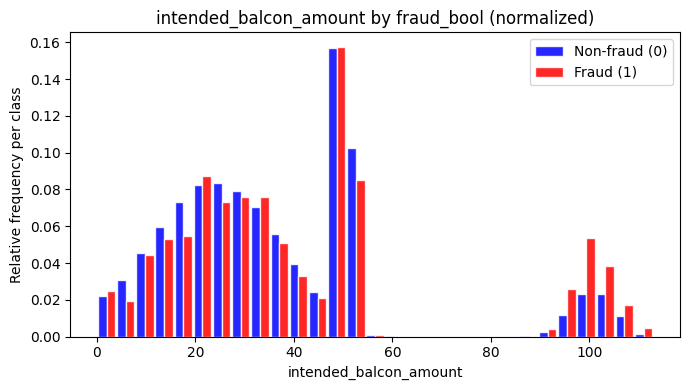

In [23]:
x0 = df.loc[df['fraud_bool'] == 0, 'intended_balcon_amount'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'intended_balcon_amount'].dropna()

x0 = x0[x0 > 0]
x1 = x1[x1 > 0]

print(x0.count(), x1.count())

plot(x0, x1, "intended_balcon_amount")

# **payment_type** *(categorical)* — Credit payment plan type (5 anonymized categories). 

In [24]:
payment_type_col = df["payment_type"]

payment_type_col.describe()

count     1000000
unique          5
top            AB
freq       370554
Name: payment_type, dtype: object

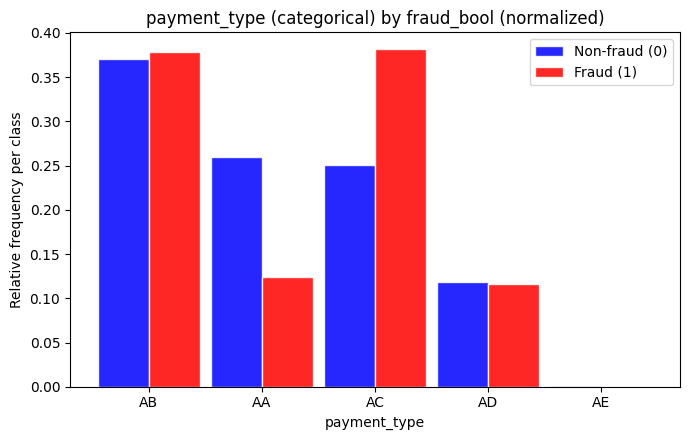

In [25]:
x0 = df.loc[df['fraud_bool'] == 0, 'payment_type'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'payment_type'].dropna()

plot_categorical(x0, x1, "payment_type")

# **zip_count_4w** *(numeric)* — # applications from same ZIP in last 4 weeks.

In [26]:
zip_count_4w_col = df["zip_count_4w"]

zip_count_4w_col.describe()

count    1000000.000000
mean        1572.692049
std         1005.374565
min            1.000000
25%          894.000000
50%         1263.000000
75%         1944.000000
max         6700.000000
Name: zip_count_4w, dtype: float64

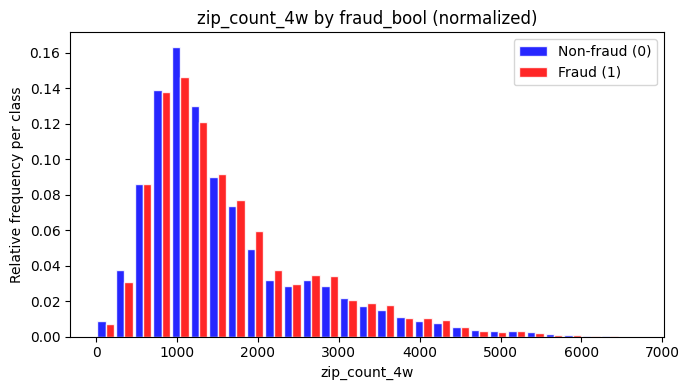

In [27]:
x0 = df.loc[df['fraud_bool'] == 0, 'zip_count_4w'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'zip_count_4w'].dropna()

plot(x0, x1, "zip_count_4w")

# **velocity_6h** *(numeric)* — Avg. applications/hour in last 6 hours.  

In [28]:
velocity_6h_col = df["velocity_6h"]
velocity_6h_col_missing = df.loc[df['velocity_6h'] < 0, "velocity_6h"]

print("We have ", velocity_6h_col_missing.count(), " missing values in the velocity_6h column. \n",velocity_6h_col.describe())

We have  44  missing values in the velocity_6h column. 
 count    1000000.000000
mean        5665.296605
std         3009.380665
min         -170.603072
25%         3436.365848
50%         5319.769349
75%         7680.717827
max        16715.565404
Name: velocity_6h, dtype: float64


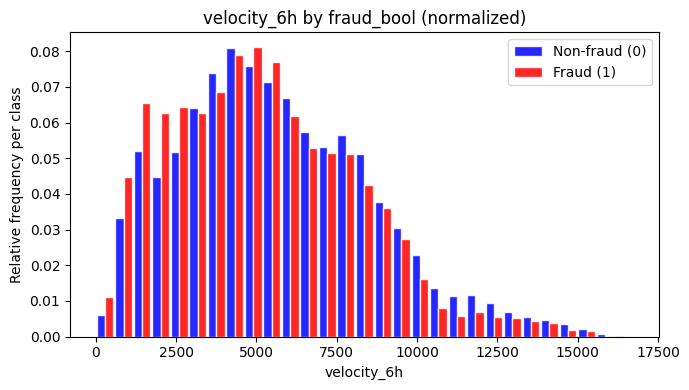

In [29]:
x0 = df.loc[df['fraud_bool'] == 0, 'velocity_6h'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'velocity_6h'].dropna()

x0 = x0[x0 > 0]
x1 = x1[x1 > 0]

plot(x0, x1, "velocity_6h")

# **velocity_24h** *(numeric)* — Avg. applications/hour in last 24 hours.  

In [30]:
velocity_24h_col = df["velocity_24h"]

velocity_24h_col.describe()

count    1000000.000000
mean        4769.781965
std         1479.212612
min         1300.307314
25%         3593.179135
50%         4749.921161
75%         5752.574191
max         9506.896596
Name: velocity_24h, dtype: float64

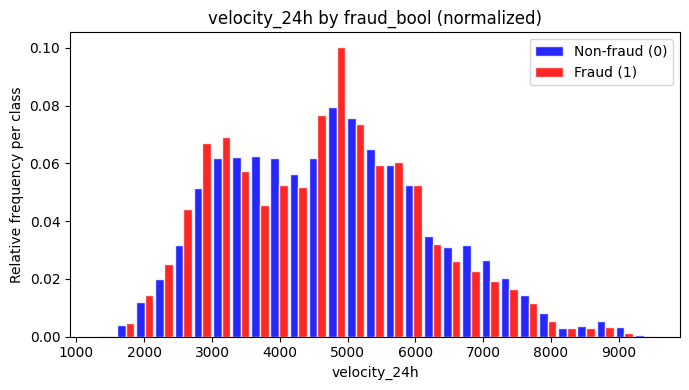

In [31]:
x0 = df.loc[df['fraud_bool'] == 0, 'velocity_24h'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'velocity_24h'].dropna()

plot(x0, x1, "velocity_24h")

# **velocity_4w** *(numeric)* — Avg. applications/hour in last 4 weeks.  

In [32]:
velocity_4w_col = df["velocity_4w"]

velocity_4w_col.describe()

count    1000000.000000
mean        4856.324016
std          919.843934
min         2825.748405
25%         4268.368423
50%         4913.436941
75%         5488.083356
max         6994.764201
Name: velocity_4w, dtype: float64

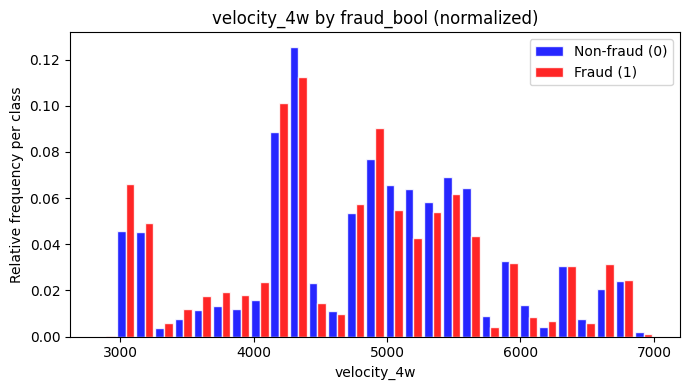

In [33]:
x0 = df.loc[df['fraud_bool'] == 0, 'velocity_4w'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'velocity_4w'].dropna()

plot(x0, x1, "velocity_4w")

# **bank_branch_count_8w** *(numeric)* — # applications in the selected branch in last 8 weeks. 

In [34]:
bank_branch_count_8w_col = df["bank_branch_count_8w"]

bank_branch_count_8w_col.describe()

count    1000000.000000
mean         184.361849
std          459.625329
min            0.000000
25%            1.000000
50%            9.000000
75%           25.000000
max         2385.000000
Name: bank_branch_count_8w, dtype: float64

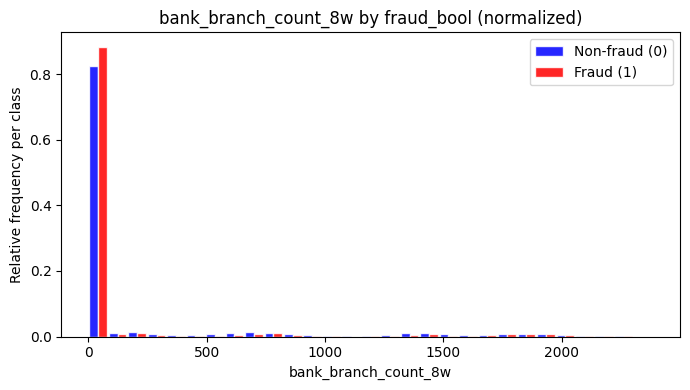

In [35]:
x0 = df.loc[df['fraud_bool'] == 0, 'bank_branch_count_8w'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'bank_branch_count_8w'].dropna()

plot(x0, x1, "bank_branch_count_8w")

# **date_of_birth_distinct_emails_4w** *(numeric)* — # distinct emails sharing the same DOB in last 4 weeks.

In [36]:
date_of_birth_distinct_emails_4w_col = df["date_of_birth_distinct_emails_4w"]

date_of_birth_distinct_emails_4w_col.describe()

count    1000000.000000
mean           9.503544
std            5.033792
min            0.000000
25%            6.000000
50%            9.000000
75%           13.000000
max           39.000000
Name: date_of_birth_distinct_emails_4w, dtype: float64

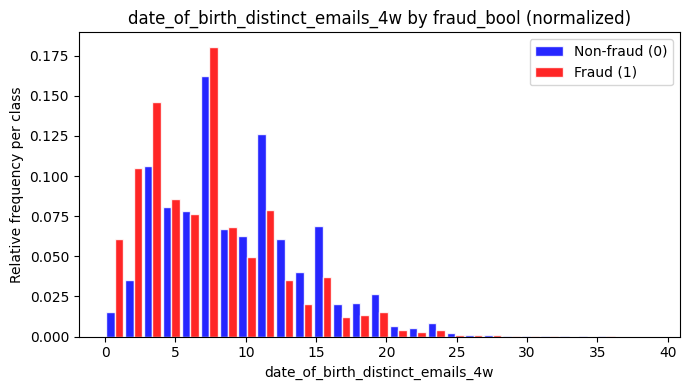

In [37]:
x0 = df.loc[df['fraud_bool'] == 0, 'date_of_birth_distinct_emails_4w'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'date_of_birth_distinct_emails_4w'].dropna()

plot(x0, x1, "date_of_birth_distinct_emails_4w")

# **employment_status** *(categorical)* — Applicant’s employment status (7 anonymized categories).  

In [38]:
employment_status_col = df["employment_status"]

employment_status_col.describe()

count     1000000
unique          7
top            CA
freq       730252
Name: employment_status, dtype: object

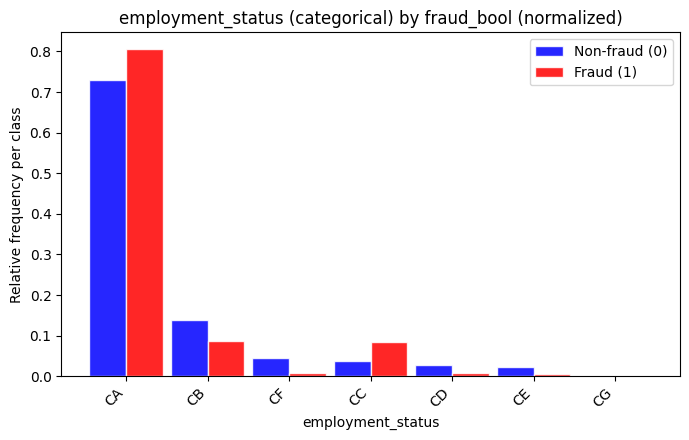

In [39]:
x0 = df.loc[df['fraud_bool'] == 0, 'employment_status'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'employment_status'].dropna()

plot_categorical(x0, x1, "employment_status")

# **credit_risk_score** *(numeric)* — Internal application risk score.  

In [40]:
credit_risk_score_col = df["credit_risk_score"]
credit_risk_score_col_missing = df.loc[df['credit_risk_score'] < 0, "credit_risk_score"]

print("We have ", credit_risk_score_col_missing.count(), " missing values in the credit_risk_score column. \n",credit_risk_score_col.describe())

We have  14445  missing values in the credit_risk_score column. 
 count    1000000.000000
mean         130.989595
std           69.681812
min         -170.000000
25%           83.000000
50%          122.000000
75%          178.000000
max          389.000000
Name: credit_risk_score, dtype: float64


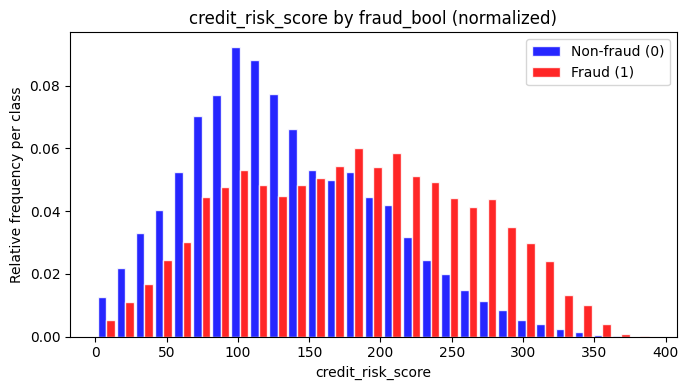

In [41]:
x0 = df.loc[df['fraud_bool'] == 0, 'credit_risk_score'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'credit_risk_score'].dropna()

x0 = x0[x0 > 0]
x1 = x1[x1 > 0]

plot(x0, x1, "credit_risk_score")

# **email_is_free** *(binary)* — Whether the email domain is free or paid. 

In [42]:
email_is_free_col = df["email_is_free"]

email_is_free_col.describe()

count    1000000.000000
mean           0.529886
std            0.499106
min            0.000000
25%            0.000000
50%            1.000000
75%            1.000000
max            1.000000
Name: email_is_free, dtype: float64

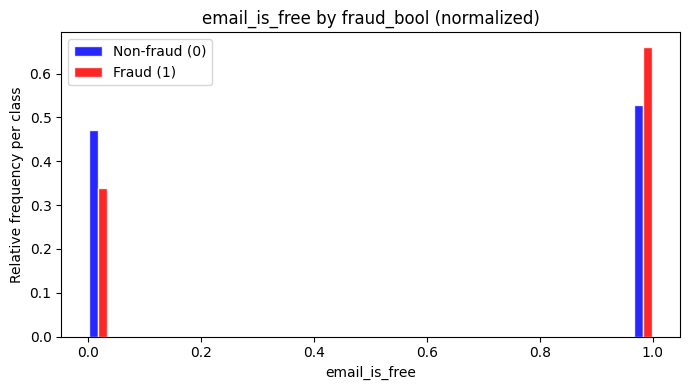

In [43]:
x0 = df.loc[df['fraud_bool'] == 0, 'email_is_free'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'email_is_free'].dropna()

plot(x0, x1, "email_is_free")

# **housing_status** *(categorical)* — Current residential status (7 anonymized categories). 

In [44]:
housing_status_col = df["housing_status"]

housing_status_col.describe()

count     1000000
unique          7
top            BC
freq       372143
Name: housing_status, dtype: object

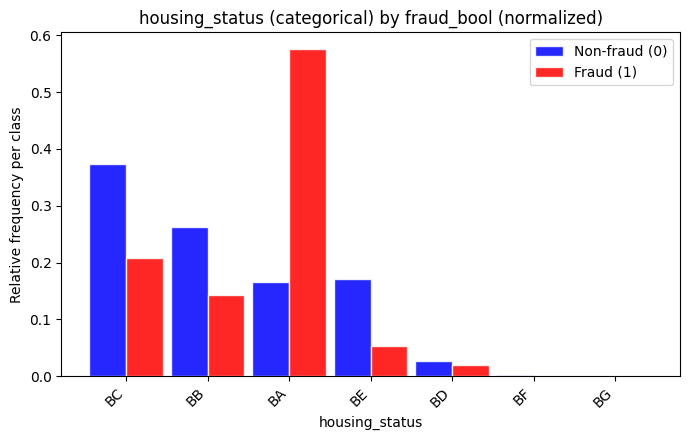

In [45]:
x0 = df.loc[df['fraud_bool'] == 0, 'housing_status'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'housing_status'].dropna()

plot_categorical(x0, x1, "housing_status")

# **phone_home_valid** *(binary)* — Validity of the provided home phone.

In [46]:
phone_home_valid_col = df["phone_home_valid"]

phone_home_valid_col.describe()

count    1000000.000000
mean           0.417077
std            0.493076
min            0.000000
25%            0.000000
50%            0.000000
75%            1.000000
max            1.000000
Name: phone_home_valid, dtype: float64

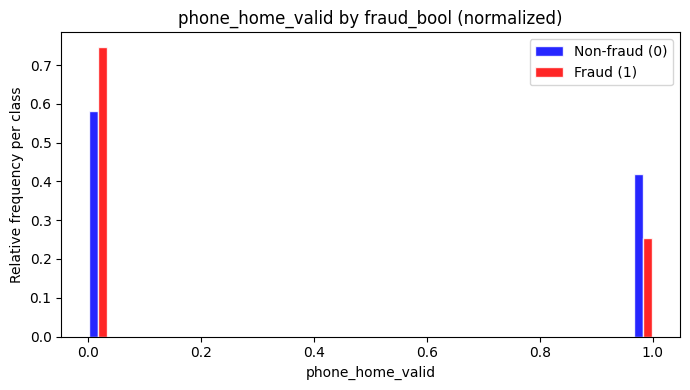

In [47]:
x0 = df.loc[df['fraud_bool'] == 0, 'phone_home_valid'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'phone_home_valid'].dropna()

plot(x0, x1, "phone_home_valid")

# **phone_mobile_valid** *(binary)* — Validity of the provided mobile phone.  

In [48]:
phone_mobile_valid_col = df["phone_mobile_valid"]

phone_mobile_valid_col.describe()

count    1000000.000000
mean           0.889676
std            0.313293
min            0.000000
25%            1.000000
50%            1.000000
75%            1.000000
max            1.000000
Name: phone_mobile_valid, dtype: float64

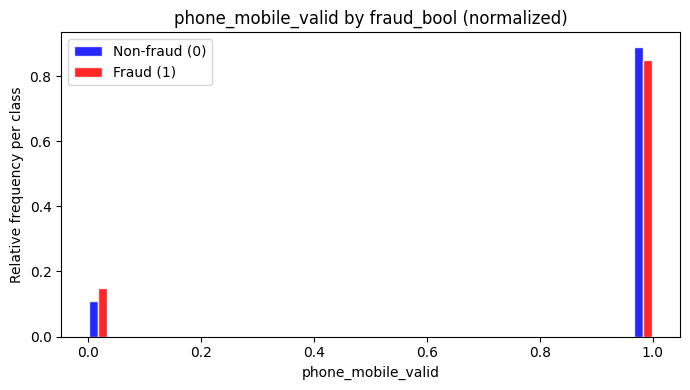

In [49]:
x0 = df.loc[df['fraud_bool'] == 0, 'phone_mobile_valid'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'phone_mobile_valid'].dropna()

plot(x0, x1, "phone_mobile_valid")

# **bank_months_count** *(numeric)* — Tenure (months) of any prior account with the bank (−1 marks missing).  

In [50]:
bank_months_count_col = df["bank_months_count"]

bank_months_count_col_missing = df.loc[df['bank_months_count'] < 0, "bank_months_count"]

print("We have ", bank_months_count_col_missing.count(), " missing values in the bank_months_count column. \n",bank_months_count_col.describe())

We have  253635  missing values in the bank_months_count column. 
 count    1000000.000000
mean          10.839303
std           12.116875
min           -1.000000
25%           -1.000000
50%            5.000000
75%           25.000000
max           32.000000
Name: bank_months_count, dtype: float64


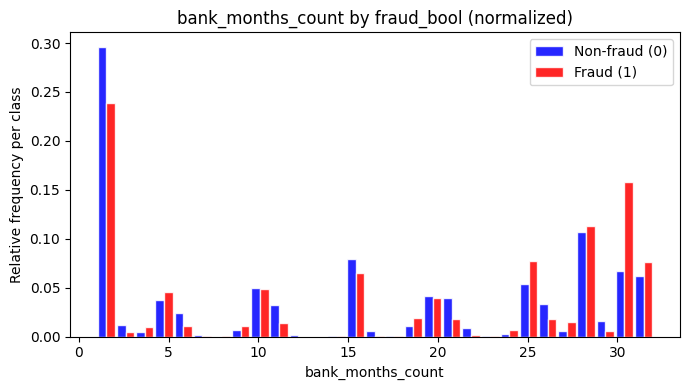

In [51]:
x0 = df.loc[df['fraud_bool'] == 0, 'bank_months_count'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'bank_months_count'].dropna()

x0 = x0[x0 > 0]
x1 = x1[x1 > 0]

plot(x0, x1, "bank_months_count")

# **has_other_cards** *(binary)* — Whether applicant has other cards at the bank.  

In [52]:
has_other_cards_col = df["has_other_cards"]

has_other_cards_col.describe()

count    1000000.000000
mean           0.222988
std            0.416251
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max            1.000000
Name: has_other_cards, dtype: float64

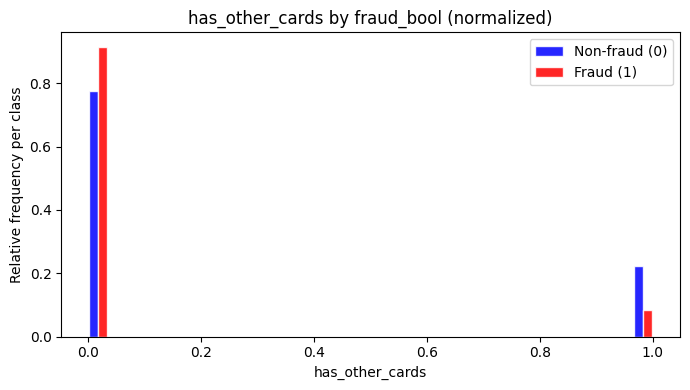

In [53]:
x0 = df.loc[df['fraud_bool'] == 0, 'has_other_cards'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'has_other_cards'].dropna()

plot(x0, x1, "has_other_cards")

# **proposed_credit_limit** *(numeric)* — Proposed credit limit (e.g., 200–2000 in Base). 

In [54]:
proposed_credit_limit_col = df["proposed_credit_limit"]

proposed_credit_limit_col.describe()

count    1000000.000000
mean         515.851010
std          487.559902
min          190.000000
25%          200.000000
50%          200.000000
75%          500.000000
max         2100.000000
Name: proposed_credit_limit, dtype: float64

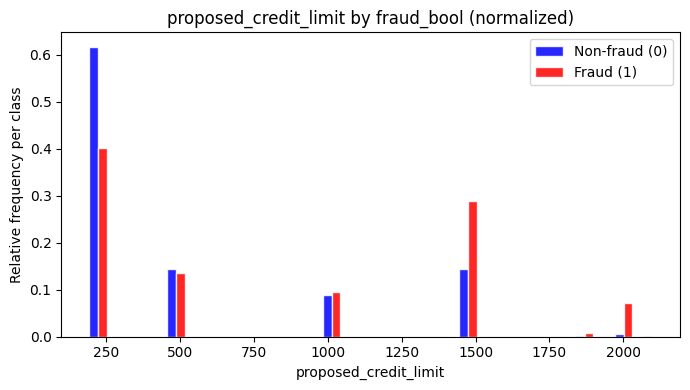

In [55]:
x0 = df.loc[df['fraud_bool'] == 0, 'proposed_credit_limit'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'proposed_credit_limit'].dropna()

plot(x0, x1, "proposed_credit_limit")

# **foreign_request** *(binary)* — Request originated from a different country than the bank’s. 

In [56]:
foreign_request_col = df["foreign_request"]

foreign_request_col.describe()

count    1000000.000000
mean           0.025242
std            0.156859
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max            1.000000
Name: foreign_request, dtype: float64

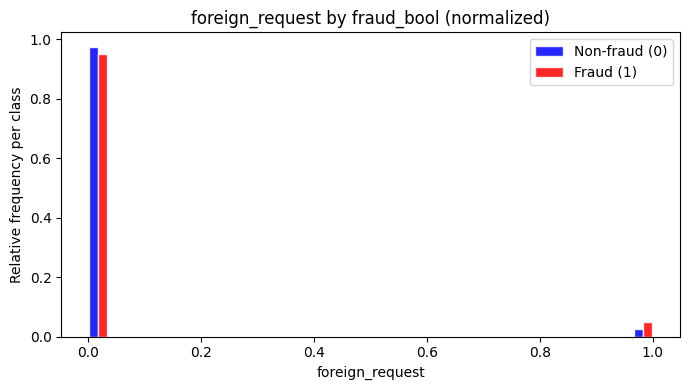

In [57]:
x0 = df.loc[df['fraud_bool'] == 0, 'foreign_request'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'foreign_request'].dropna()

plot(x0, x1, "foreign_request")

# **source** *(categorical)* — Online application source (browser **INTERNET** vs. app **TELEAPP**). 

In [58]:
source_col = df["source"]

source_col.describe()

count      1000000
unique           2
top       INTERNET
freq        992952
Name: source, dtype: object

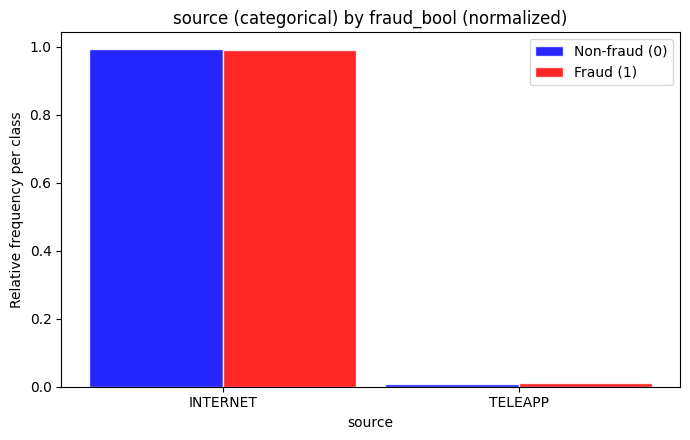

In [59]:
x0 = df.loc[df['fraud_bool'] == 0, 'source'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'source'].dropna()

plot_categorical(x0, x1, "source")

#  **session_length_in_minutes** *(numeric)* — Session duration on banking site (−1 marks missing). 

In [60]:
session_length_in_minutes_col = df["session_length_in_minutes"]

session_length_in_minutes_col_missing = df.loc[df['session_length_in_minutes'] < 0, "session_length_in_minutes"]

print("We have ", session_length_in_minutes_col_missing.count(), " missing values in the session_length_in_minutes column. \n",session_length_in_minutes_col.describe())

We have  2015  missing values in the session_length_in_minutes column. 
 count    1000000.000000
mean           7.544940
std            8.033106
min           -1.000000
25%            3.103053
50%            5.114321
75%            8.866131
max           85.899143
Name: session_length_in_minutes, dtype: float64


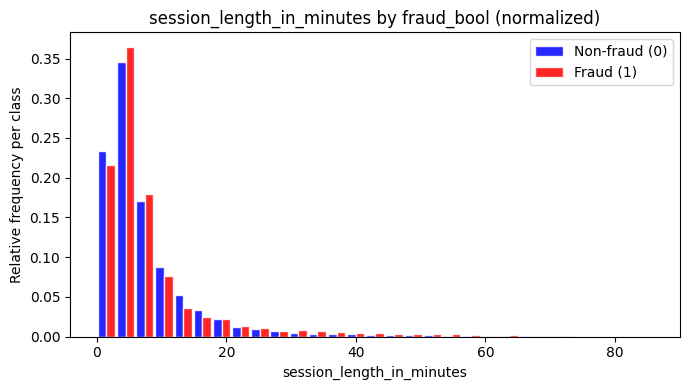

In [61]:
x0 = df.loc[df['fraud_bool'] == 0, 'session_length_in_minutes'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'session_length_in_minutes'].dropna()

x0 = x0[x0 > 0]
x1 = x1[x1 > 0]

plot(x0, x1, "session_length_in_minutes")

# **device_os** *(categorical)* — Device operating system (Windows, macOS, Linux, X11, other). 

In [62]:
device_os_col = df["device_os"]

device_os_col.describe()

count     1000000
unique          5
top         other
freq       342728
Name: device_os, dtype: object

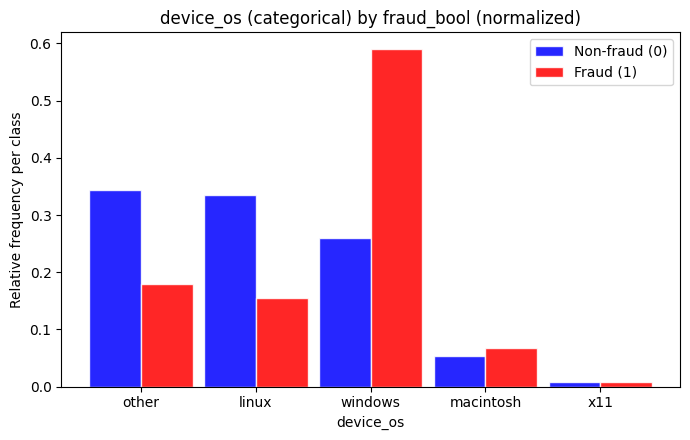

In [63]:
x0 = df.loc[df['fraud_bool'] == 0, 'device_os'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'device_os'].dropna()

plot_categorical(x0, x1, "device_os")

# **keep_alive_session** *(binary)* — Whether “keep me logged in” was enabled.  

In [64]:
keep_alive_session_col = df["keep_alive_session"]

keep_alive_session_col.describe()

count    1000000.000000
mean           0.576947
std            0.494044
min            0.000000
25%            0.000000
50%            1.000000
75%            1.000000
max            1.000000
Name: keep_alive_session, dtype: float64

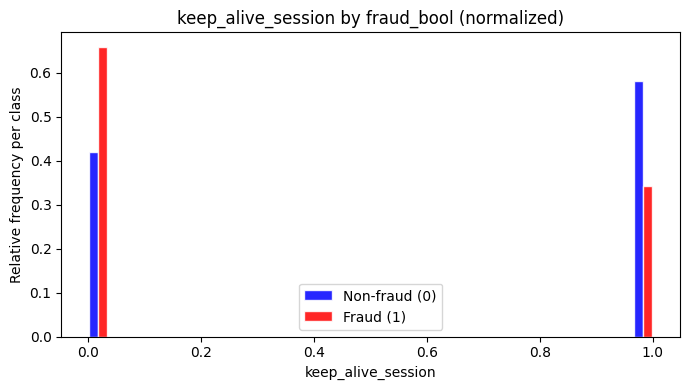

In [65]:
x0 = df.loc[df['fraud_bool'] == 0, 'keep_alive_session'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'keep_alive_session'].dropna()

plot(x0, x1, "keep_alive_session")

# **device_distinct_emails_8w** *(numeric)* — # distinct emails seen from this device in last 8 weeks (negative values mark missing).

In [66]:
device_distinct_emails_8w_col = df["device_distinct_emails_8w"]

device_distinct_emails_8w_col_missing = df.loc[df['device_distinct_emails_8w'] < 0, "device_distinct_emails_8w"]

print("We have ", device_distinct_emails_8w_col_missing.count(), " missing values in the device_distinct_emails_8w column. \n",device_distinct_emails_8w_col.describe())


We have  359  missing values in the device_distinct_emails_8w column. 
 count    1000000.000000
mean           1.018312
std            0.180761
min           -1.000000
25%            1.000000
50%            1.000000
75%            1.000000
max            2.000000
Name: device_distinct_emails_8w, dtype: float64


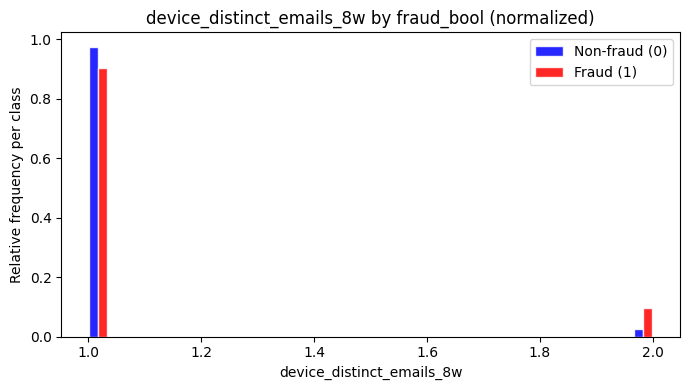

In [67]:
x0 = df.loc[df['fraud_bool'] == 0, 'device_distinct_emails_8w'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'device_distinct_emails_8w'].dropna()

x0 = x0[x0 > 0]
x1 = x1[x1 > 0]

plot(x0, x1, "device_distinct_emails_8w")

# **device_fraud_count** *(numeric)* — Count of prior fraudulent applications from this device. 

In [68]:
device_fraud_count_col = df["device_fraud_count"]

device_fraud_count_col.describe()

count    1000000.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: device_fraud_count, dtype: float64

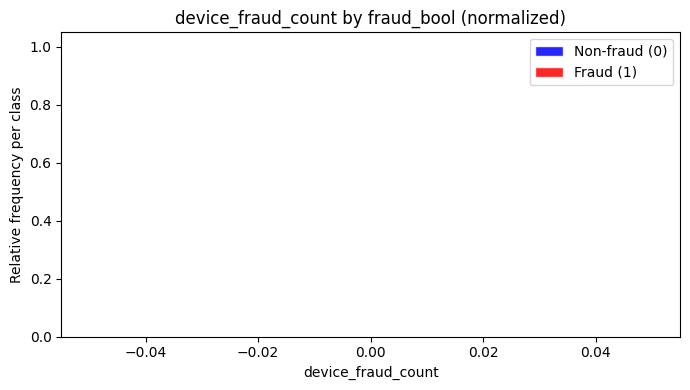

In [69]:
x0 = df.loc[df['fraud_bool'] == 0, 'device_fraud_count'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'device_fraud_count'].dropna()

plot(x0, x1, "device_fraud_count")

# **month** *(numeric)* — Month index of the application (0–7).  

In [70]:
month_col = df["month"]

month_col.describe()

count    1000000.000000
mean           3.288674
std            2.209994
min            0.000000
25%            1.000000
50%            3.000000
75%            5.000000
max            7.000000
Name: month, dtype: float64

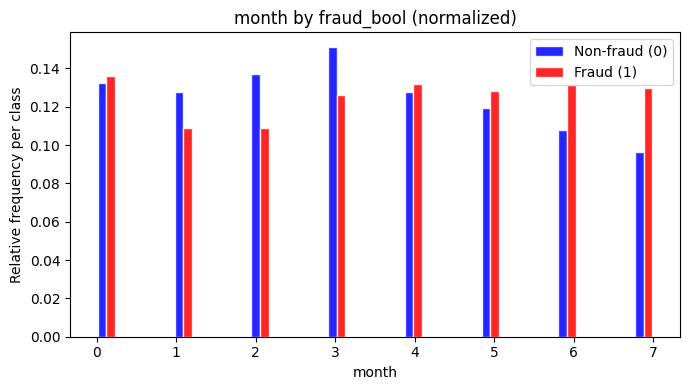

In [71]:
x0 = df.loc[df['fraud_bool'] == 0, 'month'].dropna()
x1 = df.loc[df['fraud_bool'] == 1, 'month'].dropna()

plot(x0, x1, "month")

# Comments  


There are columns/features with missing values. These are represented either by -1 values and negative values. 
In the normalization/scaling preprossesing we should set the negative missing values as -1 and do scaling/mormalization without taking into account this values.

Why?
- Ref: Géron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2ª edição, Cap. 2

- Ref: scikit-learn docs — Preprocessing data → nota sobre handling missing values